**In this notebook we show Kornia efficient data augmentation using the GPU in batch mode without additional effort. We use standard CIFAR10 dataset and `pytorch-lightning` trainer.**

## Installation

In [12]:
!pip install --quiet "pytorch-lightning>=1.3" "torchmetrics"

In [5]:
!pip install kornia

     |████████████████████████████████| 493 kB 5.2 MB/s 


In [6]:
import os

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import kornia as K

import numpy as np
from PIL import Image

## Define Kornia Data Augmentations module

In [68]:
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline

class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.75),
            ColorJitter(0.5, 0.5, 0.5, 0.5)
        )

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        return x_out

In [98]:
# we use `kornia.image_to_tensor` which casts and permutes the `PIL.Image` images in the right tensor format.

class ImagePreprocessing(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()
 
    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Image) -> torch.Tensor:
        x_tmp = np.array(x) # HxWxC
        x_tensor = K.image_to_tensor(x_tmp, keepdim=True) # CxHxW
        return x_tensor.float() / 255.0

In [9]:
import os 

preprocess = ImagePreprocessing()
dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=preprocess)
loader = DataLoader(dataset, batch_size=32)
        

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content


In [70]:
aug = DataAugmentation()

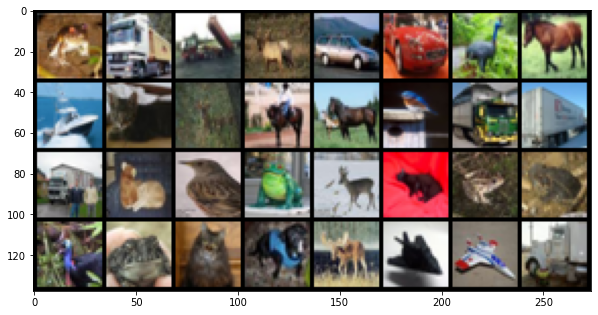

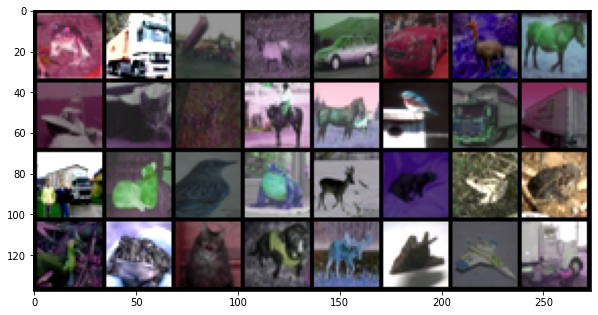

In [71]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# tensor transform to image using Kornia
def transform(data):
    return K.tensor_to_image(make_grid(data, nrow=8))

# get a batch
imgs, labels = next(iter(loader))
imgs_aug = aug(imgs)  # apply transforms
plt.figure(figsize=(10, 10))
plt.imshow(transform(imgs))
plt.figure(figsize=(10, 10))
plt.imshow(transform(imgs_aug))
plt.show()

## Define PyTorch Lightning model

In [94]:
import pytorch_lightning as pl
import torchmetrics
import torchvision


class DemoModel(pl.LightningModule):

    def __init__(self, preprocess, kornia_aug, fast_train=True):
        super(DemoModel, self).__init__()
        self.l1 = torch.nn.Linear(3 * 32 * 32, 10)
        self.preprocess = preprocess
        self.transform = kornia_aug
        self.fast_train = fast_train
        self.accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.transform is not None:
          x = self.transform(x)  # => we perform GPU/Batched data augmentation
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.accuracy(y_hat, y), prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.accuracy(y_hat, y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.l1.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=not self.fast_train, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32)
        return loader

## Training

In [86]:
kornia_model = DemoModel(preprocess, kornia_aug=aug)

kornia_trainer = pl.Trainer(
    progress_bar_refresh_rate=20,
    gpus=1,
    max_epochs=1,
    logger=pl.loggers.CSVLogger(save_dir="logs/", name="cifar10-resnet18-kornia"),
)

start = time.time()
kornia_trainer.fit(kornia_model)
print(f'kornia_model processing time with gpu: {time.time() - start}')

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | l1         | Linear             | 30.7 K
1 | preprocess | ImagePreprocessing | 0     
2 | transform  | DataAugmentation   | 0     
3 | accuracy   | Accu

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

kornia_model processing time with gpu: 14.348294496536255


Let us use traditional `torchvision.transforms` with CPU processinf in order to show efficiency of GPU Kornia implementation.

In [92]:
from torchvision import transforms \

torchvision_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

In [81]:
torchvision_model = DemoModel(torchvision_transform, aug=None)

torchvision_trainer = pl.Trainer(
    progress_bar_refresh_rate=20,
    gpus=1,
    max_epochs=1,
    logger=pl.loggers.CSVLogger(save_dir="logs/", name="cifar10-resnet18-torchvision"),
)

start = time.time()
torchvision_model.fit(torchvision_model)
print(f'kornia_model processing time with gpu: {time.time() - start}')

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | l1       | Linear   | 30.7 K
1 | accuracy | Accuracy | 0     
--------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total p

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

24.91565775871277


So, we see that the `kornia` framework is really almost 2 times faster

# Appendix

Here we compare processing time on more epochs and show that model is really training.

In [79]:
import time

In [89]:
kornia_model = DemoModel(preprocess, kornia_aug=None, fast_train=False)
kornia_trainer = pl.Trainer(
    progress_bar_refresh_rate=20,
    gpus=1,
    max_epochs=10,
    logger=pl.loggers.CSVLogger(save_dir="logs/", name="cifar10-resnet18-kornia"),
)

start = time.time()
kornia_trainer.fit(kornia_model)
print(f'kornia_model processing time with gpu: {time.time() - start}')

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | l1         | Linear             | 30.7 K
1 | preprocess | ImagePreprocessing | 0     
2 | accuracy   | Accuracy           | 0     
---------------------

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

kornia_model processing time with gpu: 232.73971891403198


   train_loss  train_acc  epoch  step  valid_loss  valid_acc
0    2.297851    0.15625      0    49         NaN        NaN
1    2.280343    0.25000      0    99         NaN        NaN
2    2.281733    0.15625      0   149         NaN        NaN
3    2.260775    0.34375      0   199         NaN        NaN
4    2.279498    0.15625      0   249         NaN        NaN


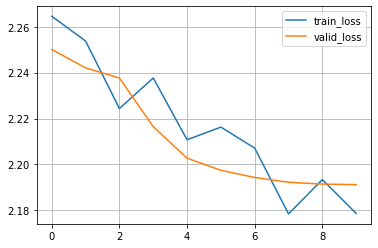

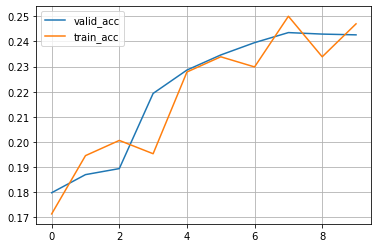

In [90]:
import pandas as pd 

metrics = pd.read_csv(f"{kornia_trainer.logger.log_dir}/metrics.csv")
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(grid=True, legend=True)
df_metrics[["valid_acc", "train_acc"]].plot(grid=True, legend=True)

In [96]:
torchvision_model = DemoModel(torchvision_transform, kornia_aug=None, fast_train=False)

torchvision_trainer = pl.Trainer(
    progress_bar_refresh_rate=20,
    gpus=1,
    max_epochs=10,
    logger=pl.loggers.CSVLogger(save_dir="logs/", name="cifar10-resnet18-torchvision"),
)

start = time.time()
torchvision_trainer.fit(torchvision_model)
print(f'torchvision_model processing time with gpu: {time.time() - start}')

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/cifar10-resnet18-torchvision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | l1       | Linear   | 30.7 K
1 | accuracy | Accuracy | 0     
--------------------------------------
30.7 K    Trainabl

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

torchvision_model processing time with gpu: 739.5915517807007


**Finally, 232s vs 739s**